In [1]:
# Sentence Embedding AraBERT (Mean Pooling)

from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np
import json

print("✅ Libraries imported successfully.")

# Load Quranic text from base file
print("📥 Loading Quranic data from 'unified_quran_data.json'...")
with open("data/unified_quran_data.json", "r", encoding="utf-8") as f:
    quran_data = json.load(f)
print(f"✅ Loaded {len(quran_data)} verses.")

# Prepare text and metadata
print("🧾 Preparing verse texts and metadata...")
verses_texts = []
verse_meta = []

for verse in quran_data:
    text = verse['text']
    verses_texts.append(text)
    verse_meta.append({
        'surah': verse['surah'],
        'verse': verse['verse'],
        'text': text
    })

print(f"✅ Prepared {len(verses_texts)} verse texts.")

# Load AraBERT model and tokenizer
model_name = "aubmindlab/bert-base-arabertv02"
print(f"🧠 Loading AraBERT model: '{model_name}'...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("✅ Model loaded and set to evaluation mode.")

# Mean Pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Generate embeddings in batches
print("🔄 Generating sentence embeddings using AraBERT with mean pooling...")
batch_size = 16
arbert_embeddings = []

for i in tqdm(range(0, len(verses_texts), batch_size)):
    batch_texts = verses_texts[i:i+batch_size]
    encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    arbert_embeddings.append(batch_embeddings.cpu())

# Concatenate all embeddings
arbert_embeddings = torch.cat(arbert_embeddings, dim=0)
print("✅ All embeddings concatenated.")

# Save output
print("💾 Saving embeddings and metadata...")
output_df = pd.DataFrame(verse_meta)
output_df['embedding'] = arbert_embeddings.tolist()

output_folder = "output/AraBERT"
output_pickle = f"{output_folder}/quran_sentence_AraBERT_embeddings.pkl"
output_csv = f"{output_folder}/quran_sentence_AraBERT_embeddings.csv"

# Create output directory if needed
import os
os.makedirs(output_folder, exist_ok=True)

output_df.to_pickle(output_pickle)
output_df.to_csv(output_csv, index=False)

print("✅ AraBERT embeddings saved to:")
print(f"   - {output_pickle}")
print(f"   - {output_csv}")
print(f"📊 Embedding matrix shape: {arbert_embeddings.shape}")


✅ Libraries imported successfully.
📥 Loading Quranic data from 'unified_quran_data.json'...
✅ Loaded 6236 verses.
🧾 Preparing verse texts and metadata...
✅ Prepared 6236 verse texts.
🧠 Loading AraBERT model: 'aubmindlab/bert-base-arabertv02'...
✅ Model loaded and set to evaluation mode.
🔄 Generating sentence embeddings using AraBERT with mean pooling...


100%|██████████| 390/390 [09:19<00:00,  1.44s/it]


✅ All embeddings concatenated.
💾 Saving embeddings and metadata...
✅ AraBERT embeddings saved to:
   - output/AraBERT/quran_sentence_AraBERT_embeddings.pkl
   - output/AraBERT/quran_sentence_AraBERT_embeddings.csv
📊 Embedding matrix shape: torch.Size([6236, 768])


In [2]:
# Root Configuration
specific_root = "صلح"

In [3]:
# Verse Embedding Extraction

import json
import torch
import pandas as pd

# Load precomputed embeddings and metadata from file
print("📥 Loading precomputed embeddings and metadata from 'quran_arbert_embeddings.pkl'...")
verse_df = pd.read_pickle("output/AraBERT/quran_sentence_AraBERT_embeddings.pkl")
print(f"✅ Loaded embeddings for {len(verse_df)} verses.")

# Load the original Quranic data to retrieve 'arabic_roots'
print("📥 Loading Quranic data from 'unified_quran_data.json'...")
with open("data/unified_quran_data.json", "r", encoding="utf-8") as f:
    quran_data = json.load(f)
print(f"✅ Loaded {len(quran_data)} verses from JSON.")

# Create a DataFrame from the JSON data (keeping relevant fields)
quran_df = pd.DataFrame(quran_data)[['surah', 'verse', 'arabic_roots']]

# Merge the embeddings DataFrame with the Quranic data to add 'arabic_roots'
merged_df = pd.merge(verse_df, quran_df, on=['surah', 'verse'], how='left')
print("✅ Merged embeddings with Arabic roots information.")

# Filter verses that contain the specified root in their 'arabic_roots' field
filtered_df = merged_df[merged_df['arabic_roots'].apply(lambda roots: specific_root in roots if isinstance(roots, list) else False)]
print(f"🔎 Found {len(filtered_df)} verses containing the root '{specific_root}'.")

# Extract the embeddings for the filtered verses and convert to a tensor
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())

# Save the filtered DataFrame (which includes metadata and embeddings) for later stages
output_pickle = f"output/AraBERT/{specific_root}_sentence_AraBERT.pkl"
filtered_df.to_pickle(output_pickle)
print(f"💾 Filtered data saved to '{output_pickle}'.")

# Optionally, also save as CSV (note: CSV may not fully preserve embeddings)
output_csv = f"output/AraBERT/{specific_root}_sentence_AraBERT.csv"
filtered_df.to_csv(output_csv, index=False)
print(f"💾 Filtered data saved to '{output_csv}'.")

📥 Loading precomputed embeddings and metadata from 'quran_arbert_embeddings.pkl'...
✅ Loaded embeddings for 6236 verses.
📥 Loading Quranic data from 'unified_quran_data.json'...
✅ Loaded 6236 verses from JSON.
✅ Merged embeddings with Arabic roots information.
🔎 Found 170 verses containing the root 'صلح'.
💾 Filtered data saved to 'output/AraBERT/صلح_sentence_AraBERT.pkl'.
💾 Filtered data saved to 'output/AraBERT/صلح_sentence_AraBERT.csv'.


In [5]:
# Dimension Reduction

import umap
import torch
import pandas as pd

# Load the filtered data with embeddings and metadata
print(f"📥 Loading filtered data from '{specific_root}_sentence_AraBERT.pkl'...")
filtered_df = pd.read_pickle(f"output/AraBERT/{specific_root}_sentence_AraBERT.pkl")
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())
print(f"✅ Loaded filtered data with {filtered_embeddings.shape[0]} verses.")

# Set the default number of dimensions for reduction
num_embeddings = filtered_embeddings.shape[0]
n_components = num_embeddings - 3
print(f"🔻 Reducing dimensions to {n_components} using UMAP...")

# Apply UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=n_components, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(filtered_embeddings.cpu())
print("✅ UMAP reduction complete. Reduced embeddings shape:", reduced_embeddings.shape)

# Save the reduced embeddings back into the DataFrame (each row now has a 'reduced_embedding')
filtered_df['reduced_embedding'] = list(reduced_embeddings)

# Save the updated DataFrame for later stages
output_file = f"output/AraBERT/{specific_root}_sentence_AraBERT_reduced.pkl"
filtered_df.to_pickle(output_file)
print(f"💾 Reduced embeddings and metadata saved to '{output_file}'.")


📥 Loading filtered data from 'صلح_sentence_AraBERT.pkl'...
✅ Loaded filtered data with 170 verses.
🔻 Reducing dimensions to 167 using UMAP...


C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP reduction complete. Reduced embeddings shape: (170, 167)
💾 Reduced embeddings and metadata saved to 'output/AraBERT/صلح_sentence_AraBERT_reduced.pkl'.


📥 Loading reduced data from 'صلح_sentence_AraBERT_reduced.pkl'...
✅ Loaded reduced data for 170 verses.
✅ Extracted embeddings array with shape: (170, 167)


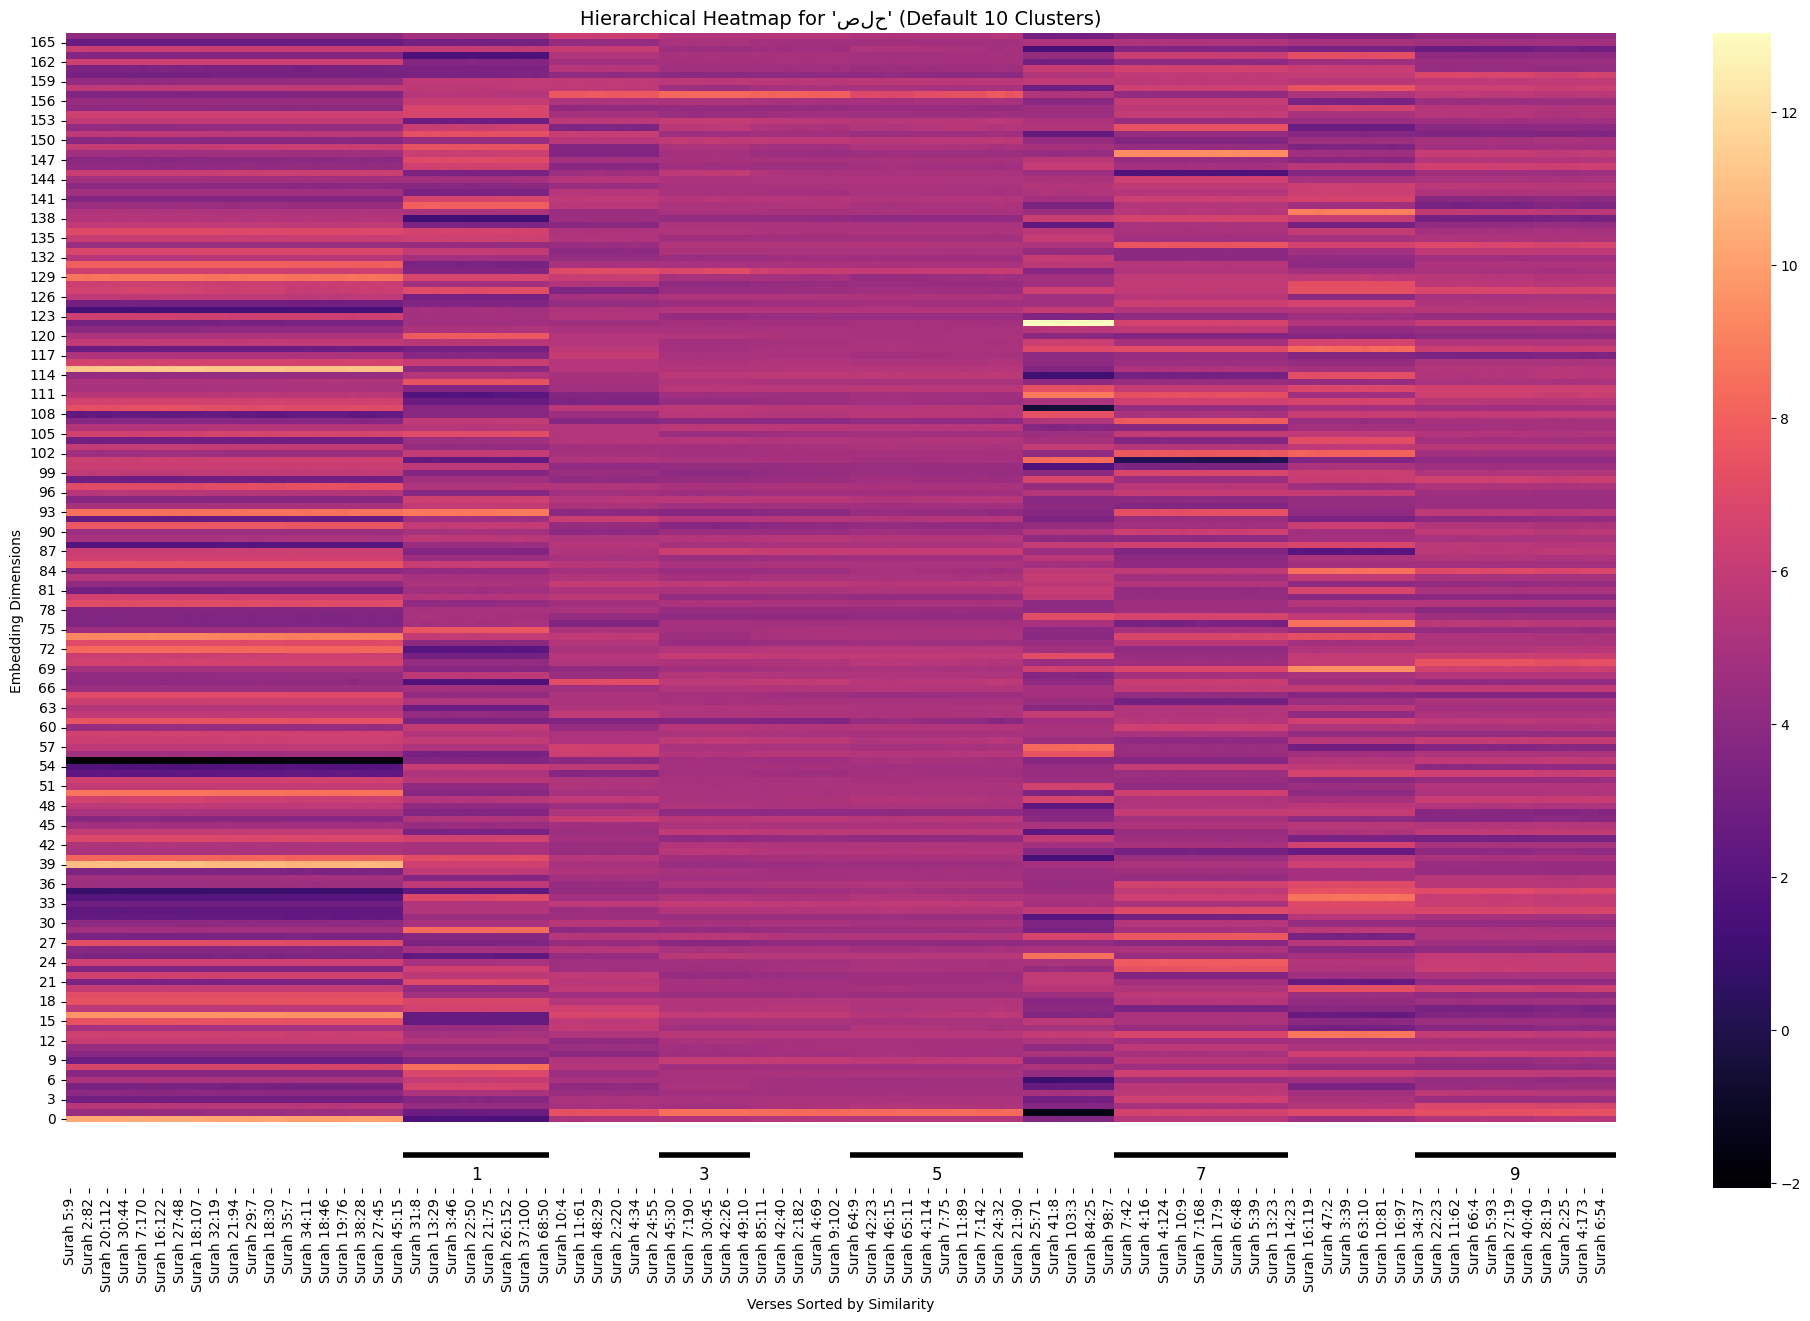

Enter desired number of clusters based on the above visualization (press Enter to keep default of 10):  


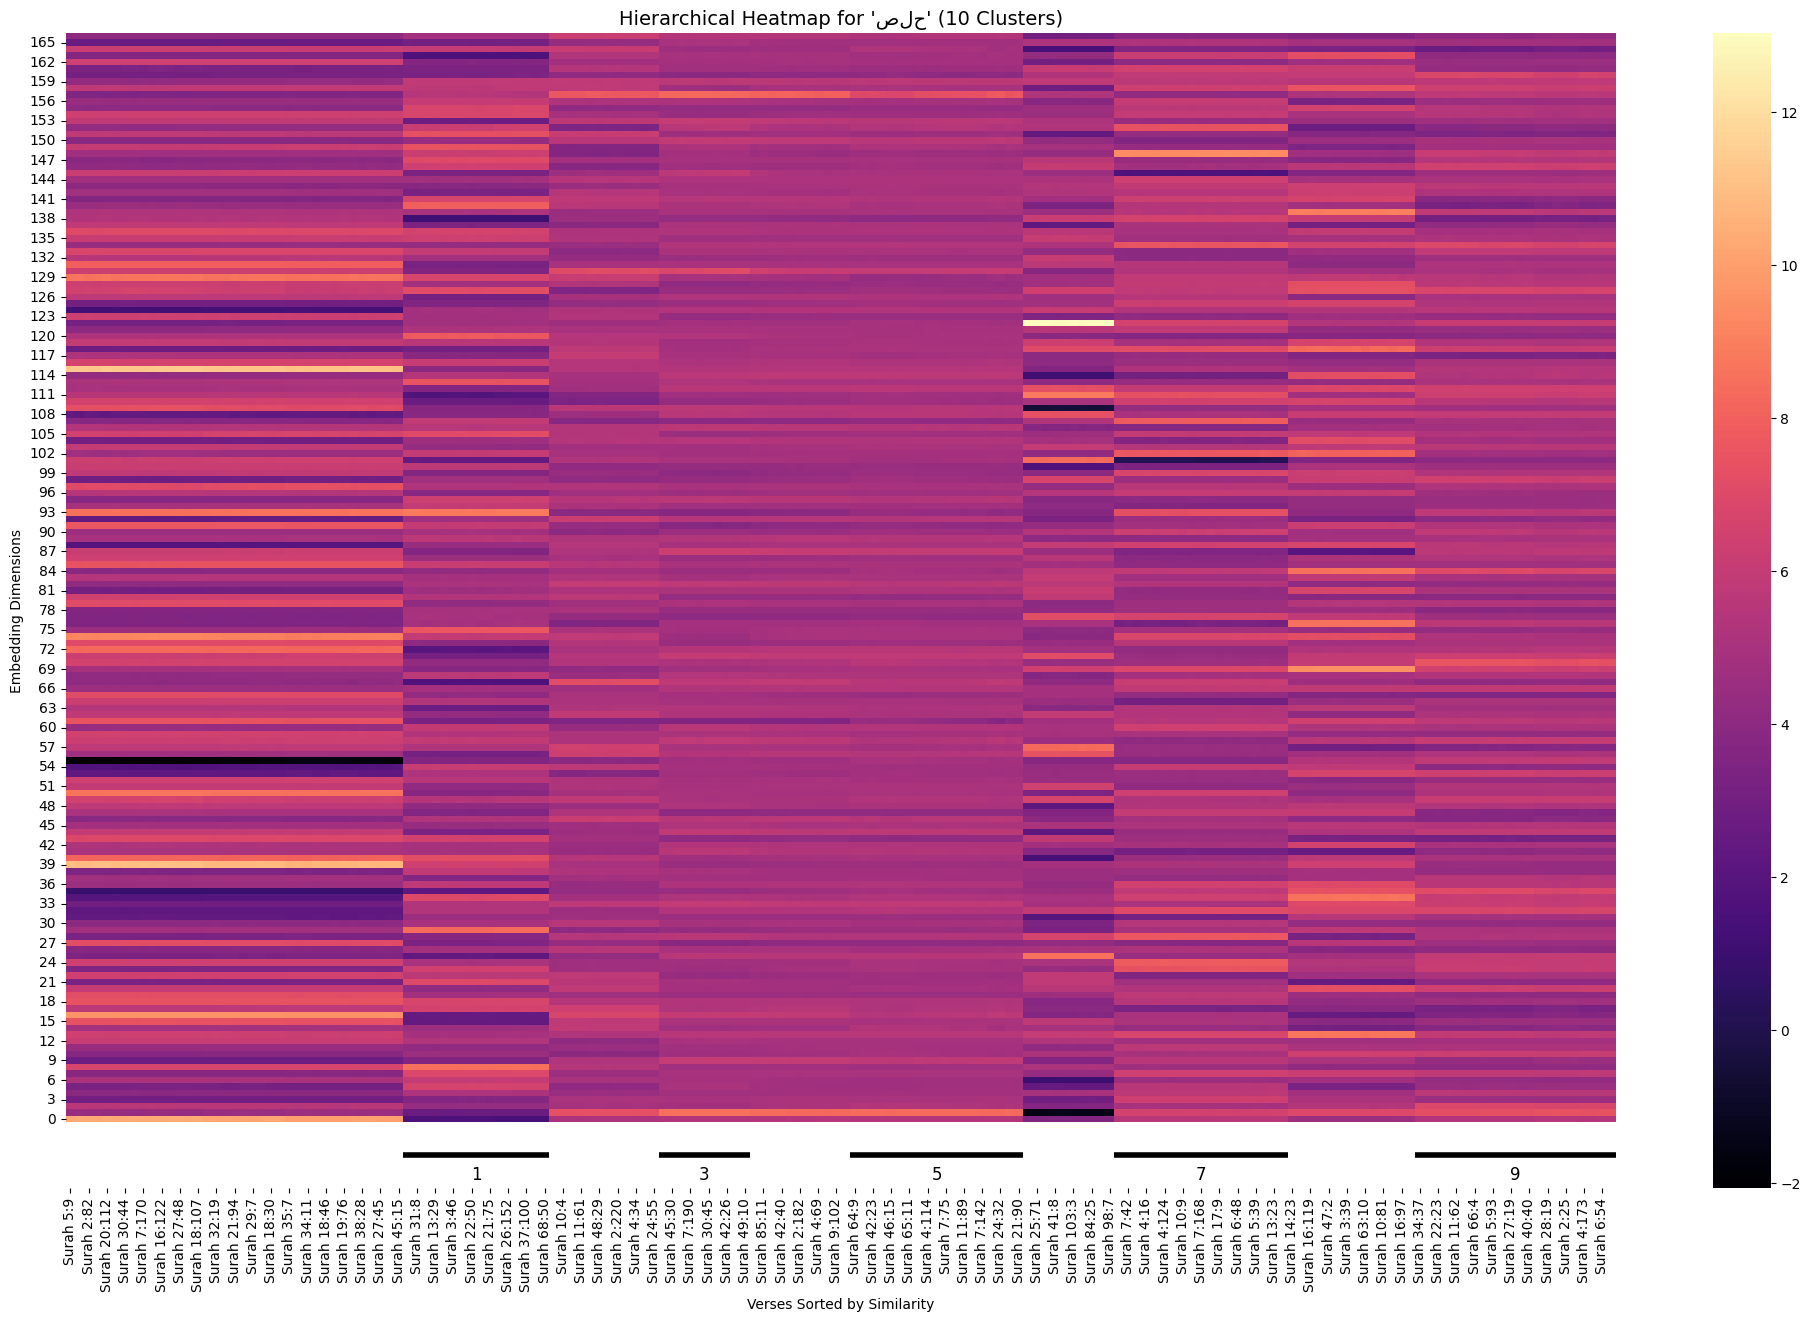

✅ Final heatmap saved to 'output/AraBERT/صلح_verses_hierarchical_heatmap.png'.
✅ Saved hierarchical clustering JSON output to 'output/AraBERT/صلح_verses_hierarchical_clusters.json'.
✅ Saved human-readable text output to 'output/AraBERT/صلح_verses-human_readable_clusters.txt'.


In [6]:
# Hierarchical Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list

# --- Config ---
default_clusters = 10  # Default clustering value for initial visualization
heatmap_output = f"output/AraBERT/{specific_root}_verses_hierarchical_heatmap.png"
cluster_json_output = f"output/AraBERT/{specific_root}_verses_hierarchical_clusters.json"
txt_output_file = f"output/AraBERT/{specific_root}_verses-human_readable_clusters.txt"

# --- Load Reduced Embeddings ---
filtered_reduced_file = f"{specific_root}_sentence_AraBERT_reduced.pkl"
print(f"📥 Loading reduced data from '{filtered_reduced_file}'...")
filtered_df = pd.read_pickle(filtered_reduced_file)
print(f"✅ Loaded reduced data for {len(filtered_df)} verses.")

# Extract reduced embeddings as a NumPy array
embeddings_array = np.array(filtered_df['reduced_embedding'].tolist())
print(f"✅ Extracted embeddings array with shape: {embeddings_array.shape}")

# Create verse labels (e.g., "Surah 1:1", "Surah 1:2", etc.)
verse_labels = filtered_df.apply(lambda row: f"Surah {row['surah']}:{row['verse']}", axis=1).tolist()

# --- Hierarchical Clustering ---
linkage_matrix = linkage(embeddings_array, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Compute default cluster labels (for visual inspection)
cluster_labels_default = fcluster(linkage_matrix, default_clusters, criterion='maxclust')
sorted_labels_default = cluster_labels_default[ordered_indices]

# --- Reorder Everything Based on Clustering ---
sorted_embeddings = embeddings_array[ordered_indices]
sorted_verse_labels = [verse_labels[i] for i in ordered_indices]

# Prepare heatmap data so that verses are along the horizontal axis
# (Transpose so rows = dimensions, columns = verses)
heatmap_data = pd.DataFrame(sorted_embeddings.T, columns=sorted_verse_labels)

# --- Plot Heatmap with Default Clusters (for inspection) ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' (Default {default_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw cluster boundaries for default clusters under the verses area
cluster_boundaries = []
prev_label = sorted_labels_default[0]
for i, label in enumerate(sorted_labels_default):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

line_colors = ["black", "white"]
for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.show()
plt.close()

# --- Ask User for New Number of Clusters ---
user_input = input(f"Enter desired number of clusters based on the above visualization (press Enter to keep default of {default_clusters}): ")
if user_input.strip() == "":
    final_clusters = default_clusters
else:
    try:
        final_clusters = int(user_input)
    except ValueError:
        print(f"Invalid input. Using default value of {default_clusters}.")
        final_clusters = default_clusters

# --- Recompute Cluster Labels Using User-Defined Number ---
cluster_labels = fcluster(linkage_matrix, final_clusters, criterion='maxclust')
sorted_labels_final = cluster_labels[ordered_indices]

# --- Replot Final Heatmap with Updated Clusters ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' ({final_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw updated cluster boundaries
cluster_boundaries = []
prev_label = sorted_labels_final[0]
for i, label in enumerate(sorted_labels_final):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.savefig(heatmap_output, dpi=600, bbox_inches="tight")
plt.show()
plt.close()
print(f"✅ Final heatmap saved to '{heatmap_output}'.")

# --- Save Human-Readable Cluster Assignments as JSON ---
# Reorder the filtered DataFrame based on the ordered indices
sorted_df = filtered_df.iloc[ordered_indices].copy()
sorted_df['cluster'] = sorted_labels_final

clusters_dict = {}
for cluster in sorted(set(sorted_labels_final)):
    clusters_dict[f"Cluster {cluster}"] = []
    cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
    for _, row in cluster_rows.iterrows():
        clusters_dict[f"Cluster {cluster}"].append({
            "surah": row['surah'],
            "verse": row['verse'],
            "text": row['text']
        })

with open(cluster_json_output, "w", encoding="utf-8") as f:
    json.dump(clusters_dict, f, ensure_ascii=False, indent=4)
print(f"✅ Saved hierarchical clustering JSON output to '{cluster_json_output}'.")

# --- Save Human-Readable Cluster Assignments as Plain Text ---
with open(txt_output_file, "w", encoding="utf-8") as f:
    for cluster in sorted(set(sorted_labels_final)):
        f.write(f"Cluster {cluster}:\n")
        cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
        for _, row in cluster_rows.iterrows():
            line = json.dumps({
                "surah": row['surah'],
                "verse": row['verse'],
                "text": row['text']
            }, ensure_ascii=False)
            f.write(line + "\n")
        f.write("\n")
print(f"✅ Saved human-readable text output to '{txt_output_file}'.")


In [8]:
# Decay Threshold

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

# Set the decay threshold value (adjust as needed)
DECAY_THRESHOLD = 0.68

# Load the full Quran embeddings DataFrame
full_df = pd.read_pickle("output/AraBERT/quran_sentence_AraBERT_embeddings.pkl")
# Ensure the full data is sorted by surah and verse
full_df = full_df.sort_values(by=['surah', 'verse']).reset_index(drop=True)
# Convert embeddings to a tensor
full_embeddings = torch.tensor(np.array(full_df['embedding'].tolist()))

# Load the filtered DataFrame (verses containing the specific root)
filtered_df = pd.read_pickle(f"output/AraBERT/{specific_root}_sentence_AraBERT.pkl")
# Sort filtered verses as well (though ordering is based on their position in full_df)
filtered_df = filtered_df.sort_values(by=['surah', 'verse']).reset_index(drop=True)

def get_context_for_anchor(anchor_idx, embeddings, threshold=DECAY_THRESHOLD):
    """
    Given an anchor index and a tensor of embeddings,
    expands the context window in both directions as long as the cosine similarity
    remains above the threshold.
    """
    anchor_emb = embeddings[anchor_idx]
    context_indices = [anchor_idx]
    
    # Look backward in the full dataset
    i = anchor_idx - 1
    while i >= 0:
        sim = F.cosine_similarity(anchor_emb.unsqueeze(0), embeddings[i].unsqueeze(0)).item()
        if sim >= threshold:
            context_indices.insert(0, i)  # Prepend to maintain order
        else:
            break
        i -= 1
    
    # Look forward in the full dataset
    i = anchor_idx + 1
    while i < len(embeddings):
        sim = F.cosine_similarity(anchor_emb.unsqueeze(0), embeddings[i].unsqueeze(0)).item()
        if sim >= threshold:
            context_indices.append(i)
        else:
            break
        i += 1
        
    return context_indices

# Prepare output for the first 20 filtered verses
output_lines = []
num_examples = min(20, len(filtered_df))
for idx in range(num_examples):
    # Retrieve the filtered verse metadata
    surah = filtered_df.iloc[idx]['surah']
    verse_num = filtered_df.iloc[idx]['verse']
    
    # Locate the corresponding index in the full DataFrame
    matching = full_df[(full_df['surah'] == surah) & (full_df['verse'] == verse_num)]
    if matching.empty:
        continue
    anchor_idx = matching.index[0]
    
    # Get context indices from the full embeddings using the decay threshold
    context_indices = get_context_for_anchor(anchor_idx, full_embeddings, threshold=DECAY_THRESHOLD)
    
    output_lines.append(f"Filtered Anchor Verse (Surah {surah}, Verse {verse_num}) [Full Index: {anchor_idx}]:")
    output_lines.append(full_df.iloc[anchor_idx]['text'])
    output_lines.append("Context Verses:")
    for i in context_indices:
        output_lines.append(f"  - (Full Index {i}, Surah {full_df.iloc[i]['surah']}, Verse {full_df.iloc[i]['verse']}): {full_df.iloc[i]['text']}")
    output_lines.append("\n" + "="*50 + "\n")

# Save the results to a text file for manual review
with open(f"output/AraBERT/{specific_root}_decay_AraBERT_threshold_context.txt", "w", encoding="utf-8") as f:
    for line in output_lines:
        f.write(line + "\n")

print(f"✅ Decay threshold context (based on full Quran embeddings) saved to '{specific_root}_decay_AraBERT_threshold_context.txt'")


✅ Decay threshold context (based on full Quran embeddings) saved to 'صلح_decay_AraBERT_threshold_context.txt'
